In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import os
os.chdir('..')

In [4]:
from data import get_dataset
from model import Model
from utils import score_clf

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
import matplotlib.cm as cm
from tqdm import tqdm
import copy
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import cdist
from PIL import Image

In [5]:
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

In [6]:
dataset1_train = get_dataset(f"mnist", test=True, known=-1)
dataset2_train = get_dataset(f"svhn", test=True, known=-1)
dataloader1 = torch.utils.data.DataLoader(
        dataset1_train, batch_size=50, shuffle=True, drop_last=False
)
dataloader2 = torch.utils.data.DataLoader(
        dataset2_train, batch_size=50, shuffle=True, drop_last=False
)

Using downloaded and verified file: datasets/test_32x32.mat


In [7]:
net = Model(mode="digits", instance_norm=False, spectral_norm=True, backbone="vat", disc_type="conditional").cuda()
#net.forward = net.forward_log_classifier
path_ours = "ours_umap"
path_semi = "confused-frost-616"
dics = torch.load(f"weights/{path_ours}.pth", map_location=torch.device('cuda'))
net.load_state_dict(dics)
net.eval();

# LRP

Update the network architecture before computing the LRP: we remove Batch normalization layers by applying them directly to the weights of the previous layer

In [8]:
for i in range(len(net.embedder.main)):
    if isinstance(net.embedder.main[i], nn.Conv2d):
        net.embedder.main[i].weight = torch.nn.parameter.Parameter(net.embedder.main[i].weight / torch.sqrt(net.embedder.main[i+1].running_var[:, None, None, None])).cuda()
        net.embedder.main[i].bias = torch.nn.parameter.Parameter((-net.embedder.main[i+1].running_mean[:])
                                                    / torch.sqrt(net.embedder.main[i+1].running_var[:])).cuda()
        net.embedder.main[i].bias = torch.nn.parameter.Parameter(net.embedder.main[i].bias * net.embedder.main[i+1].weight)
        net.embedder.main[i].bias = torch.nn.parameter.Parameter(net.embedder.main[i].bias + net.embedder.main[i+1].bias)
        net.embedder.main[i].weight = torch.nn.parameter.Parameter(net.embedder.main[i].weight * net.embedder.main[i+1].weight[:, None, None, None])
    elif isinstance(net.embedder.main[i], nn.BatchNorm2d):
        net.embedder.main[i] = nn.Identity()

We implement the LRP

In [9]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9
def newlayer(layer,g, coeff_bias=1):
    layer = copy.deepcopy(layer)
    try: layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: pass
    #if nobiasrect is False:
    #    try: layer.bias   = nn.Parameter(g(layer.bias))
    #    except AttributeError: pass
    try: layer.bias   = nn.Parameter(layer.bias*coeff_bias)
    except AttributeError: pass
    return layer
def toconv(layers):
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer,nn.Linear):
            #print(i)
            newlayer = None
            if i == 0:
                m,n = 512,layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers
def toconv2(layers):
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer,nn.Linear):
            #print(i)
            newlayer = None
            #if i == 0:
            #    m,n = 512,layer.weight.shape[0]
            #    newlayer = nn.Conv2d(m,n,7)
            #    newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            #else:
            m,n = layer.weight.shape[1],layer.weight.shape[0]
            newlayer = nn.Conv2d(m,n,1)
            newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers
def zero_grad(p):
    if p.grad is not None:
        p.grad.detach_()
        p.grad.zero_()
def expl(model, X, Y, eps=1e-3):
    mean = torch.Tensor([0.5, 0.5, 0.5]).reshape(1,-1,1,1).cuda()
    std  = torch.Tensor([0.5, 0.5, 0.5]).reshape(1,-1,1,1).cuda()
    #print("expl")
    layers = list(model._modules["embedder"]._modules['main'])
    layers += [model._modules["embedder"]._modules['classifier']]+list(model._modules['classifier'])
    L = len(layers)
    A = [X]+[None]*L
    L2 = 17
    for l in range(L):
        if l == 32:
            A[l] = A[l].reshape((len(X), -1))
        if l == L2:
            #print("req grad", l)
            A[l] = A[l].detach()
            A[l].requires_grad_(True)
        A[l+1] = layers[l].forward(A[l])
    T = Y#.reshape([len(X),10,1,1])#torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))
    R = [None]*L + [(A[-1]*T).data]
    (A[-1]*T).sum().backward()
    #print(A[L2].grad)
    R[L2] = (A[L2].grad*A[L2]).detach()
    zero_grad(A[L2])
    for l in range(0,L2)[::-1]:

        if l == 31:
            A[l] = A[l].reshape((len(X), 128, 11, 11))
        A[l] = (A[l].data).requires_grad_(True)
        #if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)
        if isinstance(layers[l],torch.nn.Conv2d):
            gamma = 0.25
            if True:#l <= 14:       
                rho = lambda p: p + gamma*p.clamp(min=0)
                incr = lambda z: z+eps
                rho_n = lambda p: p + gamma*p.clamp(max=0)
                incr_n = lambda z: z-eps
            #if 15 <= l <= 26: 
            #    rho = lambda p: p;                       
            #    incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            #    rho_n = rho                       
            #    incr_n = incr
            #if l >= 27:       
            #    rho = lambda p: p;                       
            #    incr = lambda z: z+1e-9
            #    rho_n = rho
            #    incr_n = incr
    
            zpp = incr(newlayer(layers[l],rho, coeff_bias=1+gamma).forward(A[l].clamp(min=0)))  # step 1
            znn = incr(newlayer(layers[l],rho_n, coeff_bias=0).forward(A[l].clamp(max=0))) # step 1
            z = layers[l].forward(A[l])
            zpn = incr_n(newlayer(layers[l],rho, coeff_bias=0).forward(A[l].clamp(max=0)))
            znp = incr_n(newlayer(layers[l],rho_n, coeff_bias=1+gamma).forward(A[l].clamp(min=0)))
            s_p = ((z>eps)*R[l+1]/(zpp+znn)).data                                    # step 2
            s_n = ((z<-eps)*R[l+1]/(znp+zpn)).data                                    # step 2
            ((zpp)*s_p).sum().backward(); c_pp = A[l].grad.data*1                  # step 3
            zero_grad(A[l])
            ((znn)*s_p).sum().backward(); c_nn = A[l].grad.data*1                  # step 3
            zero_grad(A[l])
            ((znp)*s_n).sum().backward(); c_np = A[l].grad.data*0                   # step 3
            zero_grad(A[l])
            ((zpn)*s_n).sum().backward(); c_pn = A[l].grad.data*0                   # step 3
            R[l] = (A[l].clamp(min=0)*(c_pp+c_np)+A[l].clamp(max=0)*(c_nn+c_pn)).data                                   # step 4
            
        elif (isinstance(layers[l],torch.nn.MaxPool2d) 
              or isinstance(layers[l],torch.nn.AvgPool2d) 
              or isinstance(layers[l], torch.nn.Linear) 
              or isinstance(layers[l], torch.nn.AdaptiveAvgPool2d)):
            
                
            incr = lambda z: (z+eps)*(z>0) + (z-eps)*(z<=0)
    
            z = incr(layers[l].forward(A[l]))  # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad.data*1                  # step 3
            zero_grad(A[l])
            #print(A[l] is None, c is None)
            R[l] = (A[l]*c).data                                   # step 4
        
        else:
        
            R[l] = R[l+1]
    
    A[0] = (A[0].data).requires_grad_(True)
    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

    z = layers[0].forward(A[0]) 
    z = z + eps * (z>=0) - eps * (z<0)                                    # step 1 (a)
    #z -= newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    #z -= newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/z).data                                                      # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c).data#(A[0]*c+lb*cp+hb*cm).data                                       # step 4
    return A, R, c.data

We now compute the average standard deviation over channels for each image, as a measure of how colorful it is, and reuse to look at heatmaps of the most colorful images

In [10]:
import cv2
dataloader1 = torch.utils.data.DataLoader(
        dataset1_train, batch_size=50, shuffle=False, drop_last=False
)
dataloader2 = torch.utils.data.DataLoader(
        dataset2_train, batch_size=50, shuffle=False, drop_last=False
)
it1 = iter(dataloader1)
it2 = iter(dataloader2)
stds1 = []
stds2 = []
for i in tqdm(range(min(len(it1), len(it2)))):
    x1, y1, _ = next(it1)
    x2, y2, _ = next(it2)
    #_, R1, _ = expl(net, x1, y1, eps=1e-9)
    _, R2, _ = expl(net, x2, y2, eps=1e-9)
    #R1 = R1[0]
    R2 = R2[0]
    #std1 = np.std(np.moveaxis(x1.detach().cpu().numpy(), 1, 3),-1).mean((1,2))
    std2 = np.std(np.moveaxis(x2.detach().cpu().numpy(), 1, 3),-1).mean((1,2))
    #stds1.append(std1)
    stds2.append(std2)
#stds1 = np.concatenate(stds1)
stds2 = np.concatenate(stds2)

100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


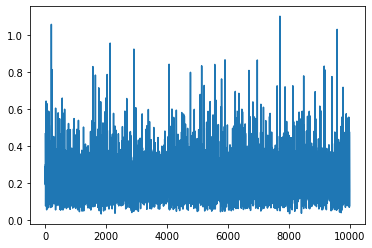

In [11]:
plt.plot(stds2)

For one of the specific images (change i to try another), shows the explanation for its coloured and black and white verison

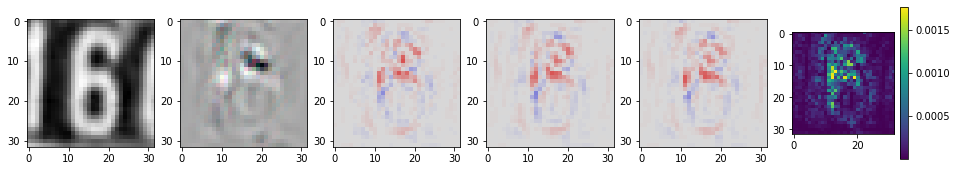

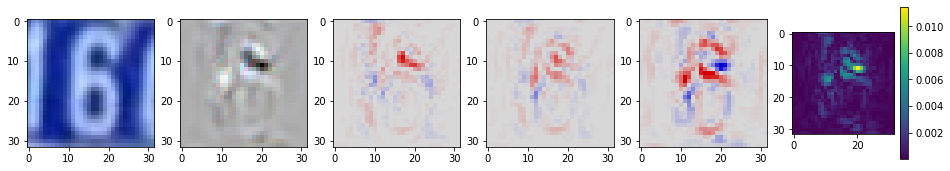

In [12]:
indices = [6965, 5791]
i = indices[-1]
coeff = 0.6
xt = dataloader2.dataset[i][0]
xt = torch.mean(xt, dim=0, keepdim=True)
xt = torch.cat([xt, xt, xt], dim=0)
xt = xt * coeff
x = np.moveaxis(xt.cpu().numpy(), 0, 2)
x = x - np.min(x)
x = x / np.max(x)
A, R, C = expl(net, xt[None, :, :, :], dataloader2.dataset[i][1][None])
grad = np.moveaxis(R[0][0].detach().cpu().numpy(), 0, 2)#.mean(-1, keepdims=True)
C = np.moveaxis(C[0].detach().cpu().numpy(), 0, 2)
C = C - np.min(C)
C = C / np.max(C)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 4))
ax1.imshow(x)
ax2.imshow(C,interpolation='nearest')#, cmap=my_cmap)
ax3.imshow(grad[:,:,0],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
ax4.imshow(grad[:,:,1],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
ax5.imshow(grad[:,:,2],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
vis = ax6.imshow(np.std(grad, -1, keepdims=True))
plt.colorbar(vis, ax=ax6, shrink=0.7, orientation = 'vertical', location="right")
plt.show()

xt = dataloader2.dataset[i][0] * coeff
x = np.moveaxis(xt.cpu().numpy(), 0, 2)
x = x - np.min(x)
x = x / np.max(x)
A, R, C = expl(net, xt[None, :, :, :], dataloader2.dataset[i][1][None])
grad = np.moveaxis(R[0][0].detach().cpu().numpy(), 0, 2)#.mean(-1, keepdims=True)
C = np.moveaxis(C[0].detach().cpu().numpy(), 0, 2)
C = C - np.min(C)
C = C / np.max(C)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 4))
ax1.imshow(x)
ax2.imshow(C,interpolation='nearest')#, cmap=my_cmap)
ax3.imshow(grad[:,:,0],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
ax4.imshow(grad[:,:,1],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
ax5.imshow(grad[:,:,2],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
vis = ax6.imshow(np.std(grad, -1, keepdims=True))
plt.colorbar(vis, ax=ax6, shrink=0.7, orientation = 'vertical', location="right")
plt.show()

Now display the 20 most colourful images and their explanations

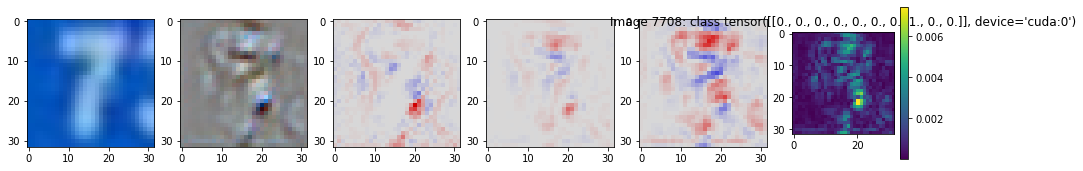

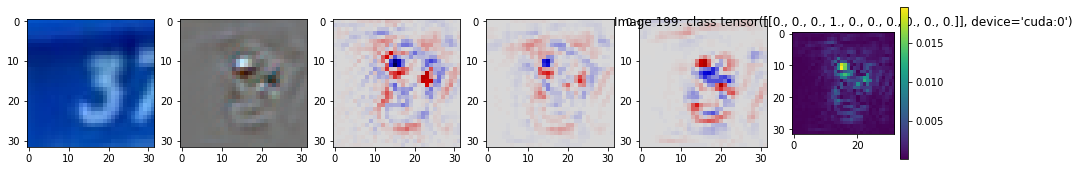

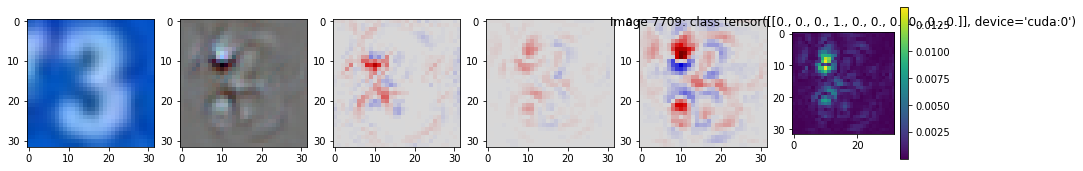

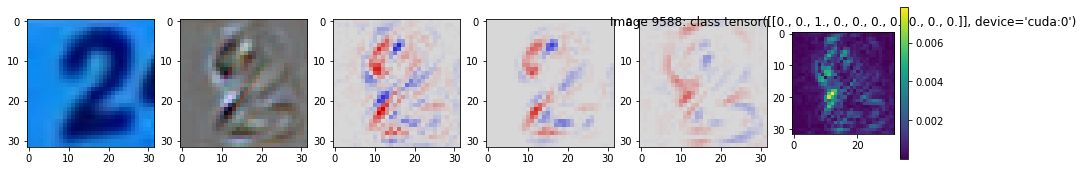

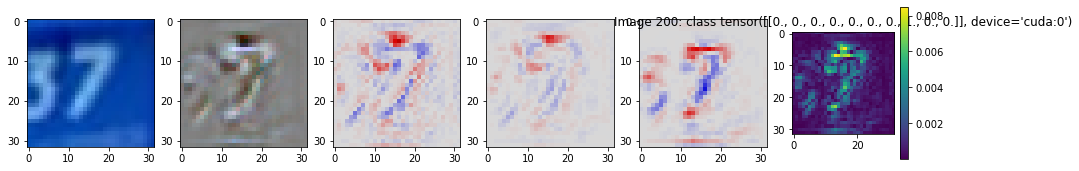

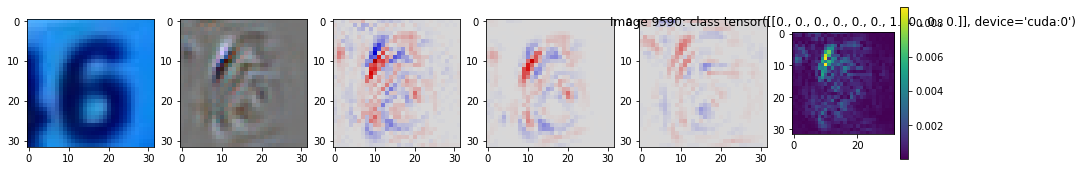

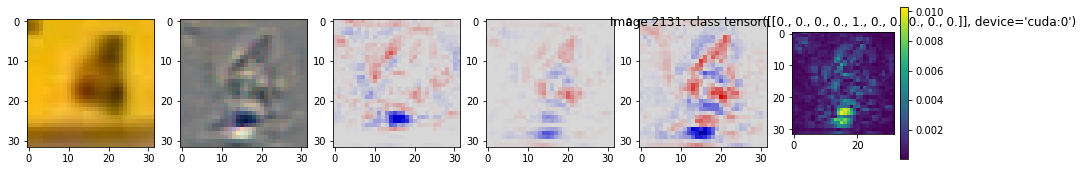

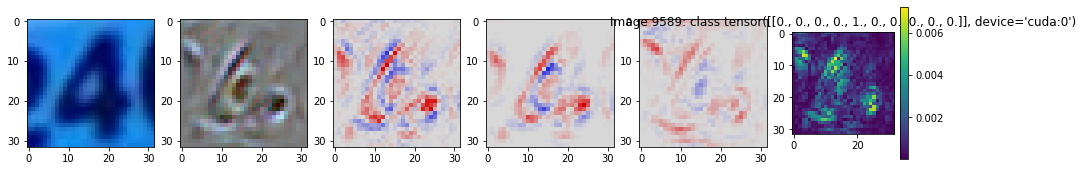

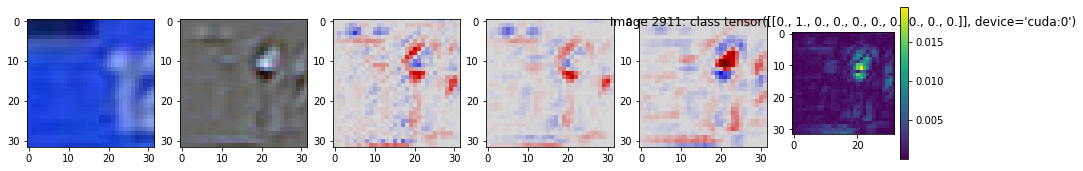

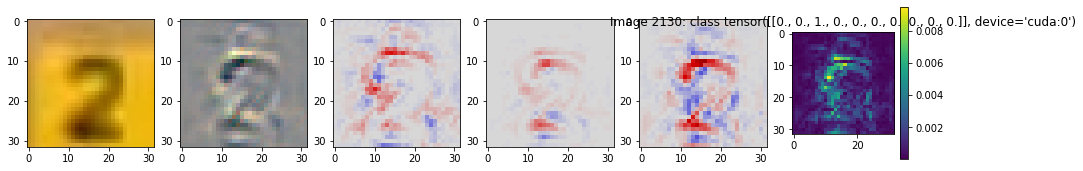

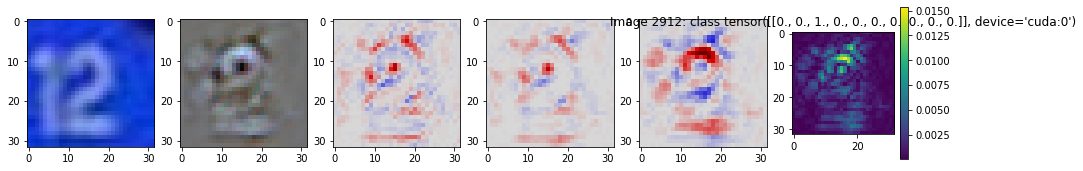

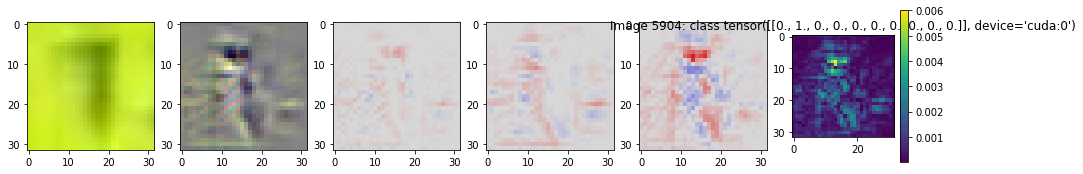

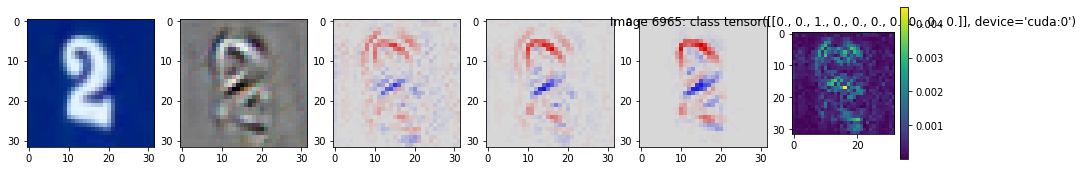

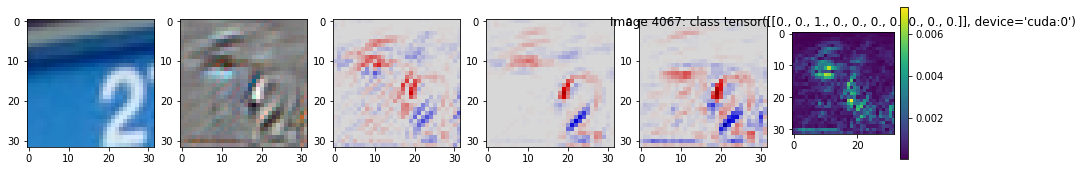

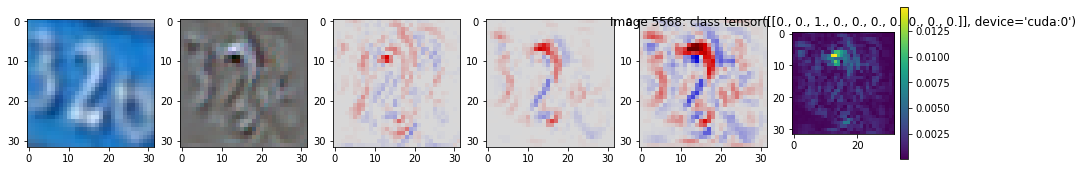

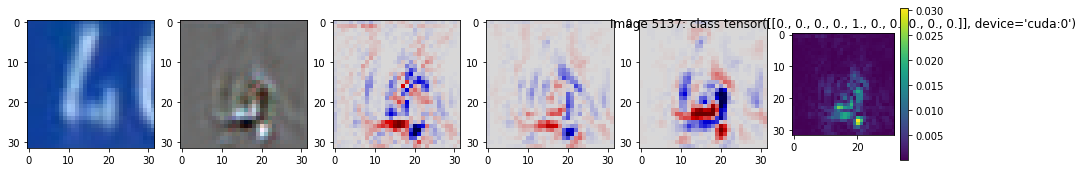

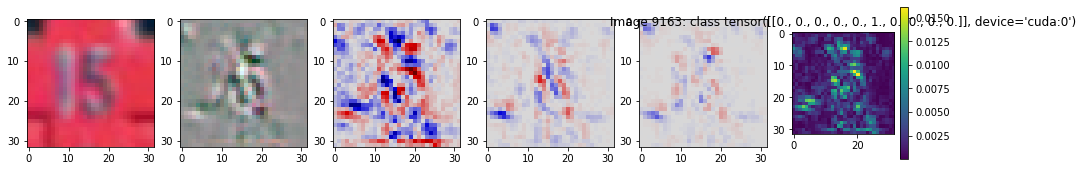

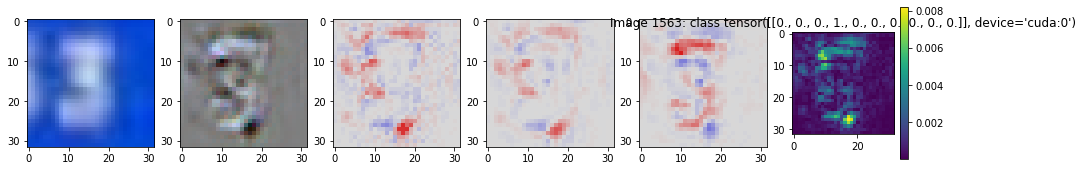

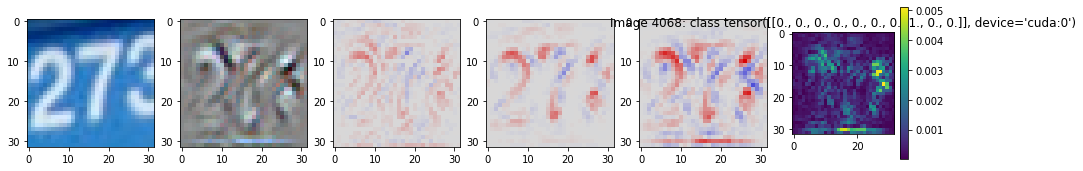

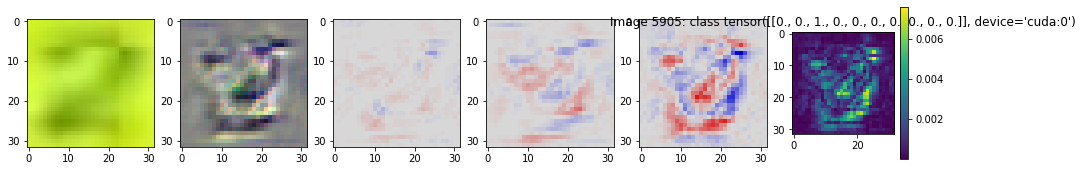

In [13]:
a1 = np.argsort(stds2)
for i in a1[::-1][:20]:
    x = np.moveaxis(dataloader2.dataset[i][0].cpu().numpy(), 0, 2)
    x = x - np.min(x)
    x = x / np.max(x)
    A, R, C = expl(net, dataloader2.dataset[i][0][None, :, :, :], dataloader2.dataset[i][1][None])
    grad = np.moveaxis(R[0][0].detach().cpu().numpy(), 0, 2)#.mean(-1, keepdims=True))
    C = np.moveaxis(C[0].detach().cpu().numpy(), 0, 2)
    C = C - np.min(C)
    C = C / np.max(C)
    #grad = grad - np.min(grad)
    #grad = grad / np.max(grad)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 4))
    ax1.imshow(x)
    ax2.imshow(C,interpolation='nearest')#, cmap=my_cmap)
    ax3.imshow(grad[:,:,0],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
    ax4.imshow(grad[:,:,1],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
    ax5.imshow(grad[:,:,2],vmin=-0.03,vmax=0.03,interpolation='nearest', cmap=my_cmap)
    vis = ax6.imshow(np.std(grad, -1, keepdims=True))
    plt.colorbar(vis, ax=ax6, shrink=0.7, orientation = 'vertical', location="right")
    plt.title(f"Image {i}: class {dataloader2.dataset[i][1][None]}")
    #plt.legend()
    plt.show()

# Process individual image
We now load and look at artificial digits as presented in the paper, and their colored heatmaps

In [14]:
imgs = []
labels = []
paths = [("datasets/artificial_digits/b2.png", 2), ("datasets/artificial_digits/c2.png", 2), 
     ("datasets/artificial_digits/b8.png", 8), ("datasets/artificial_digits/c8.png", 8)]
mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
for path, clss in paths:
    with Image.open(path) as im:
        img = np.asarray(im.convert('RGB'))
    img = np.moveaxis(img, 2, 0)[None, :, :, :]
    img = torch.Tensor(img.copy()).cuda()
    img -= mean.view((1,-1,1,1))
    img /= std.view((1,-1,1,1))
    label = torch.eye(10)[None, clss].cuda()
    #print(img.shape, label.shape)
    imgs.append(img)
    labels.append(label)
imgs = torch.cat(imgs)
labels = torch.cat(labels)
_, Ri, C = expl(net, imgs, labels, eps=1e-9)

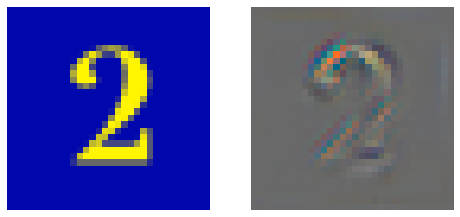

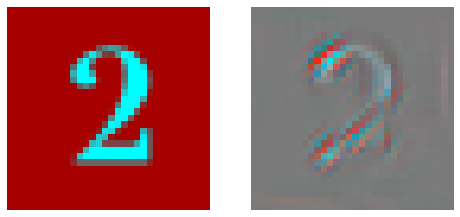

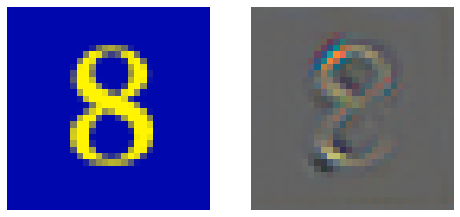

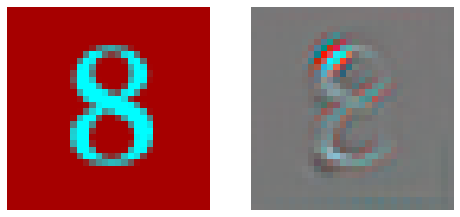

In [15]:
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)
# 10, 12
for i in range(len(imgs)):
    img = imgs[i]
    grad = C[i]#Ri[0][i]
    img = np.moveaxis(img.detach().cpu().numpy(), 0, 2)
    grad = np.moveaxis(grad.detach().cpu().numpy(), 0, 2)#.mean(-1, keepdims=True)
    grad = grad - np.min(grad)
    grad = grad / np.max(grad)
    b2 = 10*((np.abs(grad)**3.0).mean()**(1.0/3))
    img = img - np.min(img)
    img = img / np.max(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(img)
    ax1.axis("off")
    ax2.imshow(grad,vmin=0,vmax=1,interpolation='nearest', cmap=my_cmap)
    ax2.axis("off")
    #vis = ax3.imshow(np.std(grad, -1, keepdims=True))
    #plt.colorbar(vis, ax=ax3, shrink=0.7)#, orientation = 'vertical', location="right")
    plt.show()

Then, we look at the distance between these images, in feature space, and show our method aligned quite well the distributions

Predicted classes tensor([2, 2, 8, 8], device='cuda:0')


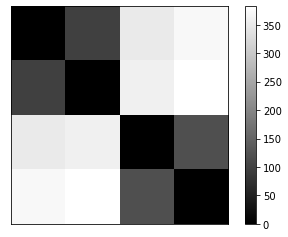

In [16]:
X = (imgs - mean[None, :, None, None]) / std[None, :, None, None]
embs1, pred, domain, mixed = net.forward(X, torch.rand((len(X), 10)).cuda(), 1)
embs = embs1.detach().cpu().numpy()
print("Predicted classes", torch.argmax(pred, -1))
dists = cdist(embs, embs)
plt.imshow(dists, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.colorbar()